In [5]:
%matplotlib inline
import numpy as np
from cosmolopy.distance import diff_comoving_volume, luminosity_distance, comoving_volume, set_omega_k_0
from fancy_plot import *
import inspect 
import scipy
from scipy.stats import lognorm, norm
import time
import sys
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit


# Conversion Factors
Mpc_to_cm = 3.086e+24
erg_to_GeV = 624.151


# StarFormationHistory (SFR), from Hopkins and Beacom 2006, unit = M_sun/yr/Mpc^3 
@np.vectorize
def HopkinsBeacom2006StarFormationRate(z):
    x = np.log10(1.+z)
    if x<0.30963:
        return np.power(10,3.28*x-1.82)
    if (x>=0.30963)and(x<0.73878):
        return np.power(10,-0.26*x-0.724)
    if x>=0.73878:
        return np.power(10,-8.0*x+4.99)

    
# Conversion factor b used to convert the source flux into an average number of neutrinos in the detector
def calc_conversion_factor(z, Gamma, Phi0): 
    u_lim=1e9/(1+z) ## upper IceCube range
    l_lim=1e2/(1+z) ## lower IceCube range

    if Gamma!=2.0:
        exponent=(2-Gamma)
        nenner=1/exponent*(u_lim**exponent-l_lim**exponent)

    else:
        nenner=(np.log(u_lim)-np.log(l_lim))
        
    # NumberofSigEvents(self._Gamma) 
    # Number of Signal Events for the whole livetime, should be estimated from Phi0, Gamma
    nsig = 512    ## Just a Guess for now
    return nsig/Phi0*(1/(1e5)**Gamma)*1/(nenner)


# Use local source Density to deduce total number of sources in the universe
def tot_num_src(redshift_evolution, cosmology, zmax, density):
    norm = 4 *np.pi * scipy.integrate.quad(lambda z:  redshift_evolution(z) * \
                                           diff_comoving_volume(z, **cosmology),
                                           0, zmax)[0]
    area = 4 * np.pi * scipy.integrate.quad(lambda z:  redshift_evolution(z) * \
                                           diff_comoving_volume(z, **cosmology),
                                           0, 0.01)[0]
    vlocal = comoving_volume(0.01, **cosmology)
    vtot = comoving_volume(zmax, **cosmology)
    Ntotal = density * vlocal / (area/norm)
    return Ntotal, norm


# Calculate the number of sources in volume and luminosity interval
def calc_dN(LF,logL0,z0, logLbinwidth, zbinwidth, N_tot, int_norm, dgamma=1):
    LF_val=LF(z0,logL0)
    return (4*np.pi*LF_val*diff_comoving_volume(z0, **cosmology)/int_norm)*logLbinwidth*zbinwidth*dgamma*N_tot

# Settings

In [6]:
# Physics Settings

density = 1*1e-7 ## 1/Mpc^3
L_nu = 4*1e50
gamma_range = [2.19] # in the original code I also integrated over gamma for some source count distributions, therefore its an array
phi0 = 1.01*1e-18

cosmology = {'omega_M_0' : 0.308, 'omega_lambda_0' : 0.692, 'h' : 0.678}
cosmology = set_omega_k_0(cosmology) #Flat universe

### Define the Redshift and Luminosity Evolution

redshift_evolution = lambda z: HopkinsBeacom2006StarFormationRate(z)
#Luminosity Function
LF = lambda z, logL : redshift_evolution(z)*\
                      np.log(10)*10**logL*lognorm.pdf(10**logL, 1, scale = L_nu)

In [18]:
# Integration Parameters 

logMu_range = [-10,6]        # expected range in log mu, 
N_Mu_bins = 2000             # number of bins for log nu histogram

z_limits = [0.04, 10.]     # Redshift limits
nzbins = 1200               # number of z bins

Lum_limits = [1e47,1e54]   # Luminosity limits 
nLbins = 1200                # number of logLuminosity bins

# Example 'Time needed for 600x600 bins: 238s'

In [19]:
N_tot, int_norm = tot_num_src(redshift_evolution, cosmology, z_limits[-1], density)

# Luminosity Distribution

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


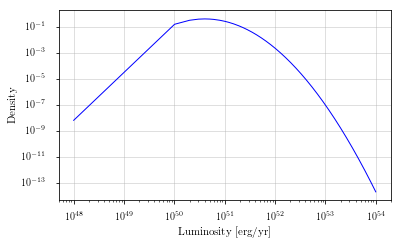

In [9]:
##use Scipy Lognormal Distribution https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html

fig, ax = newfig(0.9)
L = np.linspace(1e48, 1e54, 10000)
ax.loglog(L, L*lognorm.pdf(L, 1, scale = L_nu), color = 'blue')
ax.set_xlabel('Luminosity [erg/yr]')
ax.set_ylabel('Density')
plt.grid(True)
plt.show()

# HopkinsBeacom2006StarFormationRate

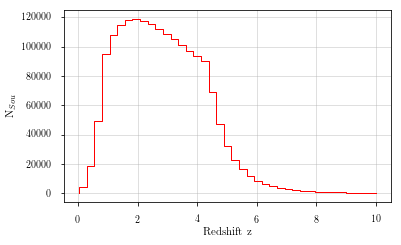

In [11]:
plot_bins = 40
z = np.linspace(z_limits[0], z_limits[1], plot_bins)
dz=(float(z_limits[1])-float(z_limits[0]))/plot_bins
fig, ax = newfig(0.9)
ax.plot(z, N_tot*4*np.pi*redshift_evolution(z)*diff_comoving_volume(z, **cosmology)/int_norm*dz,
        drawstyle='steps-pre')
ax.set_xlabel('Redshift z')
ax.set_ylabel(r'N$_{Sou}$')  ##Sources per redshift interval
plt.grid(True)
plt.show()

# Comoving Volume

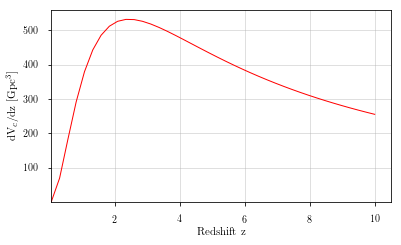

In [12]:
fig, ax = newfig(0.9)
diff_distance = diff_comoving_volume(z,**cosmology)*4*np.pi/(1000)**3
ax.plot(z, diff_distance)
plt.grid(True)
ax.set_xlabel('Redshift z')
ax.set_ylabel('dV$_c$/dz [Gpc$^3$]')
ax.set_xlim(z[0])
ax.set_ylim(np.min(diff_distance))
plt.show()

# Luminosity Function 2D Plot

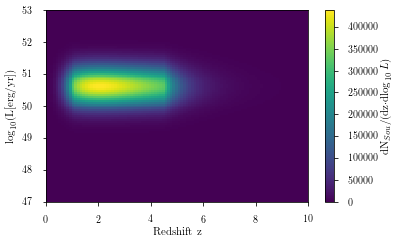

In [14]:
z = np.linspace(0, 10, 100)
log10L = np.linspace(47, 53, 100)
X,Y = np.meshgrid(z, log10L)

plt_func= lambda z,log10L : LF(z, log10L)*diff_comoving_volume(z,**cosmology)/int_norm*N_tot*4*np.pi

Z = plt_func(X,Y)

fig, ax = newfig(0.9)
p = ax.pcolor(X, Y, Z)
cb = fig.colorbar(p, label = 'dN$_{Sou}$/(dz$\cdot$d$\log_{10}L)$')
ax.set_xlabel(r'Redshift z')
ax.set_ylabel(r'$\log_{10}$(L[erg/yr])')
plt.show()

# Integration Procedure

In [20]:
flux_mode = False
print "Total number of sources {:.0f} (All-Sky)".format(N_tot)
# Setup Arrays

logMu_array=np.linspace(logMu_range[0],logMu_range[1],N_Mu_bins)

Flux_from_fixed_z=[]

dmu=[(float(10**logMu_array[i+1])-float(10**logMu_array[i])) for i in range(len(logMu_array)-1)]
dlogmu=float((logMu_range[1]-logMu_range[0]))/N_Mu_bins

zs=np.linspace(z_limits[0],z_limits[1],nzbins)
deltaz=(float(z_limits[1])-float(z_limits[0]))/nzbins

Ls=np.linspace(np.log10(Lum_limits[0]),np.log10(Lum_limits[1]),nLbins)
deltaL=(np.log10(Lum_limits[1])-np.log10(Lum_limits[0]))/nLbins


# Integration

t0=time.time()
if len(gamma_range)==1:
    gamma_ran=gamma_range
    dgamma=1
elif len(gamma_range)==2:
    gamma_ran=np.linspace(gamma_range[0],gamma_range[1],ngamma_bins)
    dgamma=(gamma_range[1]-gamma_range[0])/ngamma_bins
else:
    print "Only 1 or 2 values make sens for the spectral index range of the source"

Count_array=np.zeros(N_Mu_bins)
muError=[]
tot_bins = nLbins * nzbins
print('Starting Integration...Going to evaluate {} bins'.format(tot_bins))
N_sum = 0 
for gam_c, gam in enumerate(gamma_ran):
    Flux_from_fixed_z.append([])
    print "-"*20
    
    # Loop over redshift bins
    for z_count, z in enumerate(zs):
        bz=calc_conversion_factor(z, gam, phi0) # Conversion Factor for given z
        dlz=luminosity_distance(z, **cosmology) # Luminosity Distance
        tot_flux_from_z=0.
        
        # Loop over Luminosity bins
        for l_count, lum in enumerate(Ls): 
            run_id = z_count*nLbins+l_count
            if run_id%(tot_bins/10)==0.:
                print "{}%".format(100*run_id/tot_bins)
            # Number of Sources in 
            dN=calc_dN(LF, lum, z, deltaL, deltaz, N_tot, int_norm, dgamma)*\
               (2*np.pi*(1-np.cos(np.radians(95)))) # Last Factor: Only Northern Hemisphere 
            N_sum += dN
            if flux_mode==True: bz=1
            #Flux to Source Strength
            logmu=np.log10(erg_to_GeV*10**lum/(np.pi*1e7)/(4*np.pi*(Mpc_to_cm*dlz)**2)*bz)
            
            # Add dN to Histogram
            if logmu<logMu_range[1] and logmu>logMu_range[0]:
                tot_flux_from_z+=dN*10**logmu
                Count_array[int((logmu-logMu_range[0])*N_Mu_bins/(logMu_range[1]-logMu_range[0]))]+=dN
            else:
                muError.append(logmu)
                
        Flux_from_fixed_z.append(tot_flux_from_z)


print "Number of Mu out of Range: {}".format(len(muError))
print "Num Sou {}".format(N_sum)
t1=time.time()

print "-"*20
print "\n Time needed for {}x{} bins: {}s".format(nzbins,
                                                  nLbins,
                                                  int(t1 - t0))

Total number of sources 1846031
Starting Integration...Going to evaluate 1440000 bins
--------------------
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
Number of Mu out of Range: 0
Num Sou 12588855.4938
--------------------

 Time needed for 1200x1200 bins: 1219s


# Plotting

dN/dmu ~ mu^-2.42117885315 (Expected to be around mu^-2.5 for euclidean universe, i.e. nearby sources)


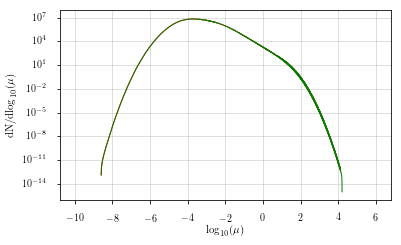

In [21]:
# Plotting

dNdlogmu=np.array(Count_array)/dlogmu
fig, ax = newfig(0.9)
ax.semilogy(logMu_array, dNdlogmu)

##Spline the Histogram
spl = UnivariateSpline([s for t,s in enumerate(logMu_array) if dNdlogmu[t]>0],
                       [s for s in dNdlogmu if s>0],
                       k=1, s=0)

# Fit Tail
popt, pcov = curve_fit(lambda x,a,b: a*x+b,
                       np.linspace(-1,0,100),
                       np.log10(spl(np.linspace(-1,0,100))))

print('dN/dmu ~ mu^{} (Expected to be around mu^-2.5 for euclidean universe, i.e. nearby sources)'.format(popt[0]-1))

ax.semilogy(logMu_array, spl(logMu_array))
ax.set_xlabel(r'$\log_{10}(\mu)$')
ax.set_ylabel(r'dN/d$\log_{10}(\mu)$')
plt.savefig('Source_Count_Distribution.png', dpi=300)
plt.grid(True)
plt.show()